In [2]:
import numpy as np
import pandas as pd
pd.set_option('precision', 10)

import scipy.sparse
import pickle
import xgboost as xgb

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'svg'

from pylab import rcParams
rcParams['figure.figsize'] = 20,5

import mix as mix
import model as pf

def modify(df):
    df = df.drop(['min slptend', 'min advRh850', 'min rainc'], axis=1)
    df.set_index('actual_date', inplace=True)
    df = df[[x for x in df.columns if 'min' in x or x == 'value']]
    return df
    
X_train = pd.read_csv('./date/X_train.csv')
X_train = modify(X_train)

X_test = pd.read_csv('./date/X_test.csv')
X_test = modify(X_test)

In [3]:
# for sklearn
# X_train = X_train.sort_index()
# X_train.reset_index(inplace=True)
# train_date = X_train[['actual_date']]
# X_train = X_train.drop(['actual_date'], axis=1)

def clean_dataset(df):
    assert isinstance(df, pd.DataFrame), "df needs to be a pd.DataFrame"
    df.dropna(inplace=True)
    indices_to_keep = ~df.isin([np.nan, np.inf, -np.inf]).any(1)
    return df[indices_to_keep].astype(np.float64)

X_train = clean_dataset(X_train)
X_test = clean_dataset(X_test)

target_train = X_train[['value']]
X_train = X_train.drop('value', axis=1) 

target_test = X_test[['value']]
X_test = X_test.drop('value', axis=1) 

In [8]:

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score, KFold
from sklearn.linear_model import LassoCV, RidgeCV, Lasso, Ridge, LinearRegression, LassoLarsIC
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

linear = LinearRegression()
linear.fit(X_train, target_train)

target_train['Linear prediction'] = linear.predict(X_train)
target_test['Linear prediction'] = linear.predict(X_test)

print('Coefficients: \n', linear.coef_)

print("Mean squared error on test: %.2f"
      % mean_squared_error(target_test.iloc[:, 0], target_test.iloc[:, 1]))

print('Variance score on test: %.2f' % r2_score(target_test.iloc[:, 0], target_test.iloc[:, 1]))

print("Mean squared error on train: %.2f"
    % mean_squared_error(target_train['value'], target_train['Linear prediction']))


Coefficients: 
 [[ 7.52580821e-02 -1.31762358e-01  1.97091348e-01 -7.44656089e-04
   5.75297630e-02  6.55376633e+03  5.28844317e-01 -7.48409734e-02
   1.23881668e-03  9.33870656e-02  1.59465764e-02  1.03718436e-04
  -9.76801984e-02  3.05832685e+02 -5.12313754e+00 -1.00539633e+04
  -4.65153289e-01  1.20421046e-05 -4.97815960e-04  4.26333405e-02
  -1.79478255e-02 -1.71148636e-02 -6.96071568e-02  3.63923273e-06
   6.26806221e-06  6.26523697e-02  1.62363748e-03  1.95609988e-01
   7.45169719e+02 -9.30478152e-02  3.13438208e-05  6.11837428e-02
  -8.56233287e-03 -2.62299846e-06 -1.32119379e-01 -2.72068760e-01
  -5.32543260e+03  1.22971238e+04 -3.59656418e-02  4.54493908e+03
   5.43372563e-01 -1.77939889e+00  3.26749775e-01  1.34952459e-01
   1.31494700e+01 -2.05941421e+04 -1.96234602e-02  2.42305932e+03
  -2.19804759e-01  5.18565041e+02 -1.82854854e-02]]
Mean squared error on test: 15.24
Variance score on test: 0.85
Mean squared error on train: 12.15


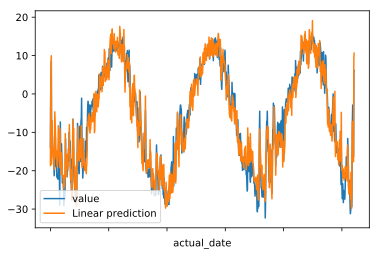

In [5]:
target_train.plot()

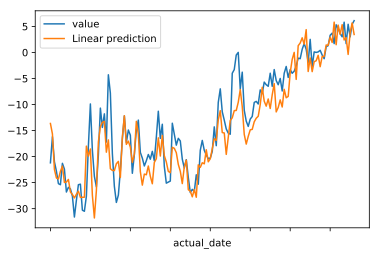

In [6]:
target_train = target_train.drop(['Linear prediction'], axis=1)
target_test.plot()

In [7]:
n_alphas = 200
ridge_alphas = np.logspace(-2, 5, n_alphas)

ridge_cv = RidgeCV(alphas=ridge_alphas,  cv=3)
ridge_cv.fit(X_train, target_train)
# В случае Ridge-регрессии никакие праметры не зануляются – они могут быть очень малыми, но не нулевыми.

target_test['Ridge prediction'] = ridge_cv.predict(X_test)

print('Alpha: %.2f' % ridge_cv.alpha_)
print('Coefficients: \n', ridge_cv.coef_)

print("Mean squared error: %.2f"
      % mean_squared_error(target_test['value'], target_test['Ridge prediction']))

print('Variance score: %.2f' % r2_score(target_test['value'], target_test['Ridge prediction']))


Alpha: 1742.63
Coefficients: 
 [[ 8.64919295e-02 -8.76951492e-02  1.87113324e-01 -1.24871673e-03
   3.14218659e-02  2.04083401e-06  1.43926311e-01 -8.18387297e-02
   1.98498624e-03  9.67489963e-02  4.01683336e-03  0.00000000e+00
  -6.00176785e-02 -1.55056112e-06 -4.31032833e-06  3.12594511e-06
  -6.14293078e-02  1.51237461e-02 -6.00167839e-04 -6.73922398e-02
   1.74117327e-02 -2.29540392e-02  1.63021619e-01  0.00000000e+00
   0.00000000e+00  3.33785272e-02  1.41585643e-03  1.72690489e-01
   1.94247896e-05 -9.36247579e-02  4.62238718e-05  1.73871077e-02
  -9.73558453e-03  0.00000000e+00 -7.56051246e-02  1.00466711e-01
   2.03456051e-08 -4.79159286e-06 -4.49962786e-02 -7.60066847e-07
   2.63110598e-01  1.43548224e-04  1.49621352e-01  1.21793065e-01
   3.84526953e-03 -1.16877886e-05 -1.41315612e-02  6.47747712e-06
   2.50341556e-02  1.99068479e-04 -1.63299498e-02]]
Mean squared error: 16.97
Variance score: 0.83


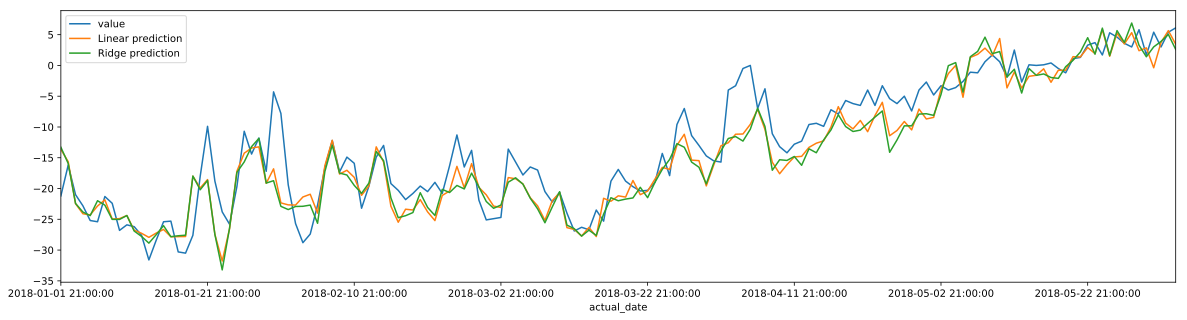

In [286]:
target_test.plot()

In [287]:
# At the end of the path, as alpha tends toward zero and
# the solution tends towards the ordinary least squares, 
# coefficients exhibit big oscillations. 
# In practise it is necessary to tune alpha in such a way 
# that a balance is maintained between both.

# coefs = []
# for a in ridge_alphas:
#     ridge = Ridge(alpha=a, fit_intercept=False)
#     ridge.fit(X_train, target_train)
#     coefs.append(ridge.coef_)
    
# ax = plt.gca()

# ax.plot(ridge_alphas, coefs)
# ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
# plt.xlabel('alpha')
# plt.ylabel('weights')
# plt.title('Ridge coefficients as a function of the regularization')
# plt.axis('tight')
# plt.show()

In [288]:
# LassoCV: coordinate descent

lasso_cv = LassoCV(cv=20, random_state=17)
lasso_cv.fit(X_train, target_train.values.ravel())

target_test['Lasso prediction'] = lasso_cv.predict(X_test)

print('Alpha: %.2f' % lasso_cv.alpha_)
print('Coefficients: \n', lasso_cv.coef_)

print("Mean squared error: %.2f"
      % mean_squared_error(target_test['value'], target_test['Lasso prediction']))

print('Variance score: %.2f' % r2_score(target_test['value'], target_test['Lasso prediction']))

# # LassoLarsIC, основаны на критериях AIC / BIC.
# model_bic = LassoLarsIC(criterion='bic')
# model_bic.fit(X_train, target_train.values.ravel())
# target_test['Lasso BIC prediction'] = lasso_cv.predict(X_test)

# print()
# print('Alpha: %.2f' % model_bic.alpha_)
# print('Coefficients: \n', model_bic.coef_)

# print("Mean squared error: %.2f"
#       % mean_squared_error(target_test['value'], target_test['Lasso BIC prediction']))

# print('Variance score: %.2f' % r2_score(target_test['value'], target_test['Lasso BIC prediction']))

# model_aic = LassoLarsIC(criterion='aic')
# model_aic.fit(X_train, target_train.values.ravel())
# target_test['Lasso AIC prediction'] = lasso_cv.predict(X_test)

# print()
# print('Alpha: %.2f' % model_aic.alpha_)
# print('Coefficients: \n', model_aic.coef_)

# print("Mean squared error: %.2f"
#       % mean_squared_error(target_test['value'], target_test['Lasso AIC prediction']))

# print('Variance score: %.2f' % r2_score(target_test['value'], target_test['Lasso AIC prediction']))


Alpha: 40.25
Coefficients: 
 [  0.00000000e+00  -0.00000000e+00   0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -0.00000000e+00   0.00000000e+00   0.00000000e+00
   2.93914301e-03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00  -0.00000000e+00   0.00000000e+00  -0.00000000e+00
  -0.00000000e+00   0.00000000e+00  -3.77225512e-03   0.00000000e+00
   0.00000000e+00  -0.00000000e+00   2.46106488e-01   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00  -0.00000000e+00  -2.11706545e-05   0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00   0.00000000e+00
  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00  -0.00000000e+00
   0.00000000e+00  -0.00000000e+00   2.83156828e-01   0.00000000e+00
  -0.00000000e+00   0.00000000e+00   0.00000000e+00  -0.00000000e+00
   0.00000000e+00   0.00000000e+00   0.00000000e+00]
Mean squared error: 29.25
Variance score: 0.71


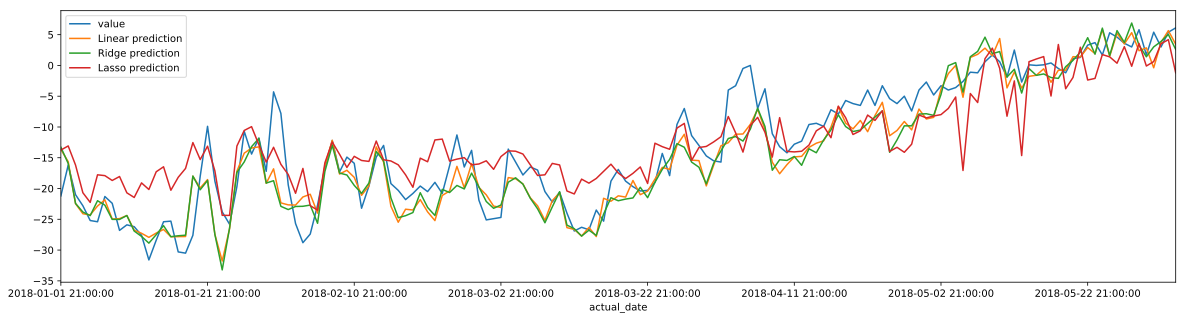

In [289]:
# target_test = target_test.drop(['Lasso AIC prediction', 'Lasso BIC prediction'], axis=1)
target_test.plot()

In [290]:
# from sklearn.feature_selection import SelectFromModel

# model = SelectFromModel(ridge_cv, prefit=True)
# X_new_train = model.transform(X_train)
# X_new_test = model.transform(X_test)

# linear = LinearRegression()
# linear.fit(X_new_train, target_train)
# target_test['Select Linear prediction'] = linear.predict(X_new_test)

# print('Coefficients: \n', linear.coef_)

# print("Mean squared error: %.2f"
#       % mean_squared_error(target_test['value'], target_test['Select Linear prediction']))

# print('Variance score: %.2f'
#       % r2_score(target_test['value'], target_test['Select Linear prediction']))


In [291]:
# Метод cross_val_score максимизирует метрику, 
# так что вместо минимизации MSE сделаем максимизацию отрицательного MSE – neg_mean_squared_error.

# cross_val_score(Lasso(lasso_cv.alpha_), X_train, target_train, cv=3, 
#                 scoring='neg_mean_squared_error')

# # Чтобы все-таки трактовать результат в терминах MSE, 
# # выведем модуль среднего значения метрики neg_mean_squared_error на кросс-валидации.
# print("Mean squared error: %.2f" %
#     abs(np.mean(cross_val_score(Lasso(lasso_cv.alpha_), X_train, target_train, cv=3, 
#                         scoring='neg_mean_squared_error'))) )

# Еще один неоднозначный момент: 
# LassoCV сортирует значения параметров по убыванию – так проще оптимизировать. 
# Из-за этого может показаться, что оптимизация параметра α работает неправильно

# lasso_cv.alphas[:10]  значения параметров на входе
# lasso_cv.alphas_[:10] преобразованные значения параметров
 # неверно
# plt.plot(lasso_cv.alphas, lasso_cv.mse_path_.mean(1))
# plt.axvline(lasso_cv.alpha_, c='g');

# plt.plot(lasso_cv.alphas_, lasso_cv.mse_path_.mean(1)) # верно
# plt.axvline(lasso_cv.alpha_, c='g');

In [292]:
# from cycler import cycler

# model = Lasso()

# coefs = []
# for a in alphas:
#     model.set_params(alpha=a)
#     model.fit(X_train, target_train)
#     coefs.append(model.coef_)
    
# ax = plt.gca()
# ax.set_prop_cycle(cycler('color', 
#                           ['b', 'r', 'g', 'c', 'k', 'y', 'm']))

# ax.plot(alphas, coefs)
# ax.set_xscale('log')
# ax.set_xlim(ax.get_xlim()[::-1])  # reverse axis
# plt.xlabel('alpha')
# plt.ylabel('weights')
# plt.title('Lasso coefficients as a function of the regularization')
# plt.axis('tight')
# plt.show();

In [293]:
# from sklearn.compose import TransformedTargetRegressor

# regr_trans = TransformedTargetRegressor(regressor=RidgeCV(),
#                                         func=np.log1p,
#                                         inverse_func=np.expm1)
# regr_trans.fit(X_train, target_train)
# y_pred = regr_trans.predict(X_test)

# plt.scatter(y_test, y_pred)
# plt.plot([-30, 30], [-30, 30], '--k')
# plt.set_ylabel('Target predicted')
# plt.set_xlabel('True Target')
# plt.set_title('Ridge regression \n with target transformation')
# plt.text(100, 1750, r'$R^2$=%.2f, MAE=%.2f' % (
#     r2_score(target_test['value'], y_pred), median_absolute_error(target_test['value'], y_pred)))


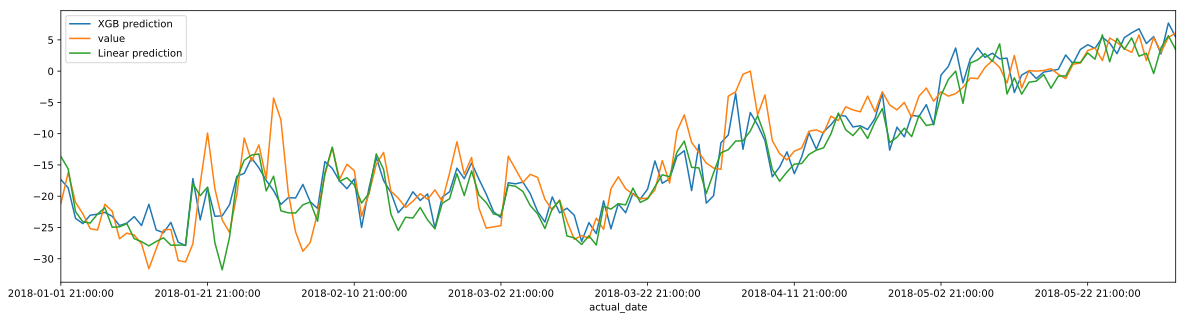

In [295]:

reg = xgb.XGBRegressor(n_estimators=1000, verbosity=3)

reg.fit(X_train, target_train) # Change verbose to True if you want to see it train

# # # This is a metric that simply sums up how many times each feature is split on.
# # _ = xgb.plot_importance(reg, height=0.9)

target_test['XGB prediction'] = reg.predict(X_test)


target_test[['XGB prediction', 'value', 'Linear prediction']].plot()

In [297]:
mean_squared_error(y_true=target_test['value'],
                   y_pred=target_test['XGB prediction'])

16.28424419158015

In [300]:

mean_absolute_error(y_true=target_test['value'],
                   y_pred=target_test['XGB prediction'])

3.010077348877402